<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="../slides/A1.00.-Modelo_epidemiologico_Individual_estocastico.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/local-slides-darkgreen" alt="localslides" title="Local Slides"></a>
&nbsp;

<!--NAVIGATOR-->
[<- O cenário da cidade do Rio de Janeiro: distribuição inicial de infectados](32.00-Cenario_Rio_Distribuicao_Infectados.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) 

---


# Atributos dos indivíduos

- O modelo considera separadamente cada indivíduo da população. No caso do Rio de Janeiro, são quase sete milhões de indivíduos. 


- Para cada indivíduo, temos os seguintes atributos:

    - a sua localização de sua residência, incluindo coordenadas espaciais, bairro e bloco correspondendo a uma subdivisão da região em blocos;
    
    - a sua idade;
    
    - O grau relativo de potencial de infectividade do indivíduo;
    
- A seguir, descrevemos melhor como esses atributos são construídos.

In [1]:
import datetime

import os, sys

import math

import random

import numpy as np
from scipy import stats
from scipy.interpolate import interp2d

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import episiming

In [3]:
sns.set_style("darkgrid")

In [4]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 03/Jul/2020


## Representação dos indivíduos

- Para uma população de $N$ indivíduos, cada indivíduo é representado por um **índice** $i=1, ..., N$.

- Associado a cada índice, ou seja, para cada indivíduo, temos os seguintes atributos:

    - A sua **posição** $(x_i, y_i)$ em coordenadas espaciais.

    - O índice linear (*flattened*) $b_i$ do **bloco** em que está localizado, considerando que a região é compartimentalizada em blocos.

    - O **bairro** do indivíduo conforme uma indexação $c_i$, i.e. cada $c_i$ é um número associado a um determinado bairro.

    - A **idade** $a_i$ do indivíduo.

    - O **grau relativo de infectividade** $\rho_i$ do indivíduo.
    
**Observação:** O grau de infectividade, naturalmente, é um grau potencial, que só é efetivo caso o indivíduo se torne infectado.

## Localização

- A distribuição populacional é feita a partir de dados de densidade populacional obtidos do [LandScan](https://landscan.ornl.gov).

- Os dados do [LandScan](https://landscan.ornl.gov) são disponibilizados por blocos de aproximadamente $1 \;\textrm{km}^2$.

- Cado indivíduo é, então, associado, também, ao bloco ao qual pertence.

- Esses dados são cruzados com dados de localização dos bairros para associar, ainda, cada indivíduo a um bairro.

### Resolução do Lanscan

- Os dados do [LandScan](https://landscan.ornl.gov) são, na verdade, do número de habitantes por bloco de 30" x 30" (onde " indica segundos de arco).

- A metragem exata dos blocos depende da latitude. As coordenadas geográficas do (centro do) Rio de Janeiro são latitude: 22° 54' 30'' Sul e longitude: 43° 11' 47'' Oeste.

- No equador, um minuto de arco corresponde a uma milha náutica, i.e. 1852 metros. Corrigindo para latitude de 23 graus e dividindo por 2, obtemos

    $$ \text{30" de arco longitudinal no Rio de Janeiro} \approx \frac{\cos\left(\frac{180\pi}{23}\right) \times 1852}{2} \approx 852.39 \;\text{metros}.
    $$

- Já a distância latitudinal não é muito afetada pela latitude e temos

    $$ \text{30" de arco latitudinal no Rio de Janeiro} \approx \text{30" de arco latitudinal na linha do equador} = \frac{1852}{2} \;\text{metros} = 926 \;\text{metros}.
    $$
    
- Cada segundo de arco nos dá uma resolução, no Rio de Janeiro, de $28.41 \times 30.87$ metros quadrados.

### Matriz populacional obtida do Landscan

- Do [LandScan](https://landscan.ornl.gov), obtemos uma matriz com, entre outras coisas, informações da população em cada bloco de 30" x 30".

- No caso do Rio de Janeiro, obtemos um matrix 39 x 83.

- A matriz foi trabalhada no [QGIS](https://qgis.org/en/site/) e uma **matriz populacional**, em formato numpy, foi obtida, apenas com os dados de população por bloco.

- Alguns blocos contém o valor -1, indicando falta de informação.

- Outros contém o valor 0, indicando que não há habitantes no bloco, o que pode indicar um bloco no mar, na baía de Guanabara ou em algum área terrestre desocupada, como alguma área de reserva ambiental.

- Abaixo, carregamos a matriz na memória, substituímos o valor -1 por 0 e obtemos algumas informações.

In [5]:
landscan_rio = np.load('../input/dados_rio/landscan_rio.npy').astype(int)
landscan_rio = np.maximum(landscan_rio, 0)
landscan_rio_xscale = 0.85239
landscan_rio_yscale = 0.926
landscan_rio_xdim = landscan_rio.shape[1]
landscan_rio_ydim = landscan_rio.shape[0]
landscan_rio_xextent = landscan_rio_xdim*landscan_rio_xscale
landscan_rio_yextent = landscan_rio_ydim*landscan_rio_yscale

print(f'Dimensão da matriz de blocos: {landscan_rio.shape}')
print('Região representada pelo LandScan: ',
      f'{landscan_rio_xextent:.3f} x {landscan_rio_yextent:.3f} km^2')
print(f'Total de blocos: {landscan_rio_xdim*landscan_rio_ydim}')
print(f'Total de blocos habitados: {(landscan_rio[landscan_rio>0]>1).sum()}')
print(f'População: {landscan_rio.sum()}')

Dimensão da matriz de blocos: (39, 83)
Região representada pelo LandScan:  70.748 x 36.114 km^2
Total de blocos: 3237
Total de blocos habitados: 1454
População: 6857853


### Visualização em escala logarítmica

- Usamos escala logarítmica para visualizar melhor a variação na população:

$$ \ln( 1 + \textrm{população})
$$

- Ajustamos, ainda, as escalas dos eixos de acordo com a resolução do [LandScan](https://landscan.ornl.gov) para o Rio de Janeiro

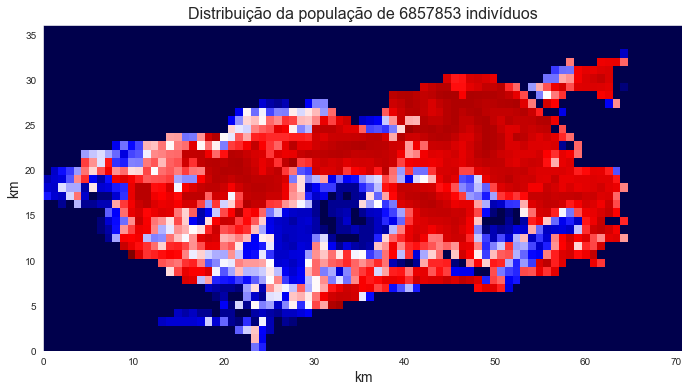

In [6]:
plt.figure(figsize=(12,6))
plt.imshow(np.log(1 + landscan_rio), cmap='seismic', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent])
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Distribuição da população de {int(landscan_rio.sum())} indivíduos', fontsize=16)
plt.show()

### Sobre a resolução da malha

- Observe que a malha está visivelmente grosseira.

- Se usarmos essa resolução, corremos o risco de distribuir os indivíduos em locais inabitáveis, como o mar e a baía.

- Além disso, com essa resolução, a associação com os bairros pode gerar inconsistências.

- Para resolver isso, fazemos o seguinte:
    
    - carregamos uma matriz de bairros com uma resolução melhor; e
    
    - interpolamos os dados da matriz populacional para a resolução mais fina da matriz de bairros.
    
- Naturalmente, a interpolação deve preservar o total de habitantes de cada bloco da matriz populacional.

### Bairros

- A matriz de bairros é obtida de a partir de dados de ...

- Um arquivo do tipo [shapefile](https://desktop.arcgis.com/en/arcmap/10.3/manage-data/shapefiles/what-is-a-shapefile.htm) é obtido, com a delimitação de cada bairro.

- No [QGIS](https://qgis.org/en/site/), após definirmos uma resolução espacial, exportamos os dados para uma **matriz de bairros**, associando cada bloco a um bairro.

- Aqui, definimos uma resolução 100 vezes maior do que a obtida do [LandScan](https://landscan.ornl.gov). Mais precisamente, 10 vezes mais fina em cada direção.

- Obtemos, assim, uma matriz 390 x 830.

- Cada bloco da matriz de bairros cobre uma área de 3" x 3" kilômetros quadrados, ou seja, aproximadamente 85,2 x 92,6 metros quadrados.

- Cada elemento da matriz é um número inteiro; cada número inteiro representando um bairro.

- São 163 bairros.

In [7]:
geoloc_Bairros_MRJ_fino = np.load(
        os.path.join('..', 'input', 'dados_rio','geoloc_Bairros_MRJ_fino.npy')
    ).astype(int)

In [8]:
print(f'Dimensão da matriz de blocos: {geoloc_Bairros_MRJ_fino.shape}')
print(f'Número de bairros: {geoloc_Bairros_MRJ_fino.max()}')

Dimensão da matriz de blocos: (390, 830)
Número de bairros: 163


### Visualizando a divisão administrativa do Rio de Janeiro

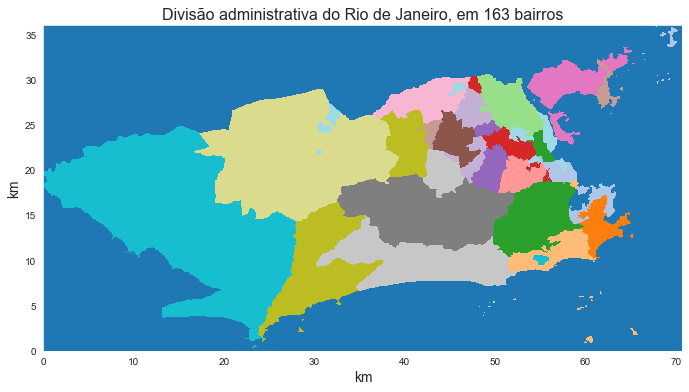

In [9]:
plt.figure(figsize=(12,6))
plt.imshow(geoloc_Bairros_MRJ_fino, cmap='tab20', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent])
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Divisão administrativa do Rio de Janeiro, em {geoloc_Bairros_MRJ_fino.max()} bairros',
          fontsize=16)
plt.show()

### Refinamento da malha populacional

- Uma estratégia simples é apenas dividir uniformemente o total da população de cada bloco da matriz populacional pelo número de subblocos habitados da matriz de bairros.

- Outra estratégia é interpolar os dados, mas nesse caso devemos tomar cuidado em preservar o total da população de cada bloco.

- Uma solução para essa interpolação é a seguinte:

    - interpretar o número de habitantes por bloco como uma distribuição de probabilidade;
    
    - interpolar essa distribuição de maneira linear por partes;
    
- distribuir os habitantes de cada bloco pelos bloquinhos, usando a distribuição de probabilidades interpolada como pesos. 

In [10]:
def refina_matriz_populacional(landscan_rio, geoloc_Bairros_MRJ_fino):

    tx_refinamento_x = geoloc_Bairros_MRJ_fino.shape[1]/landscan_rio.shape[1]
    tx_refinamento_y = geoloc_Bairros_MRJ_fino.shape[0]/landscan_rio.shape[0]

    x = np.arange(landscan_rio.shape[1])
    y = np.arange(landscan_rio.shape[0])

    x_fino = np.arange(0, landscan_rio.shape[1], 1/tx_refinamento_x)
    y_fino = np.arange(0, landscan_rio.shape[0], 1/tx_refinamento_y)

    f = interp2d(x, y, landscan_rio, kind='linear')
    landscan_rio_fino = f(x_fino, y_fino)*np.minimum(geoloc_Bairros_MRJ_fino,1)
    
    return landscan_rio_fino

In [11]:
tx_refinamento_x = int(geoloc_Bairros_MRJ_fino.shape[1]/landscan_rio.shape[1])
tx_refinamento_y = int(geoloc_Bairros_MRJ_fino.shape[0]/landscan_rio.shape[0])

xs = list(range(landscan_rio.shape[1]))
ys = list(range(landscan_rio.shape[0]))

In [12]:
xs_fino = np.arange(0, landscan_rio.shape[1], 1/tx_refinamento_x)
ys_fino = np.arange(0, landscan_rio.shape[0], 1/tx_refinamento_y)

f = interp2d(xs, ys, landscan_rio, kind='linear')
landscan_interp = f(xs_fino, ys_fino)*np.minimum(geoloc_Bairros_MRJ_fino,1)

In [13]:
sem_bairros = list()
for j in xs:
    for i in ys:
        if landscan_rio[i,j]:
            landscan_interp_local = landscan_interp[i*tx_refinamento_y:(i+1)*tx_refinamento_y,
                                                    j*tx_refinamento_x:(j+1)*tx_refinamento_x].flatten()
            if landscan_interp_local.sum() == 0:
                sem_bairros.append([i,j])
#            distrib_0 = np.rint(landscan_rio[i,j]*landscan_interp_local/landscan_interp_local.sum()).astype('int')
#            print(landscan_rio[i,j] - distrib_0.sum())
#            np.random.choice(landscan_rio[x,y], tx_refinamento_x*tx_refinamento_y,
#                             replace=False, p=prob_fino_local)

landbad = np.zeros_like(landscan_rio)
for ij in sem_bairros:
    landbad[ij[0], ij[1]] = landscan_rio[ij[0], ij[1]]

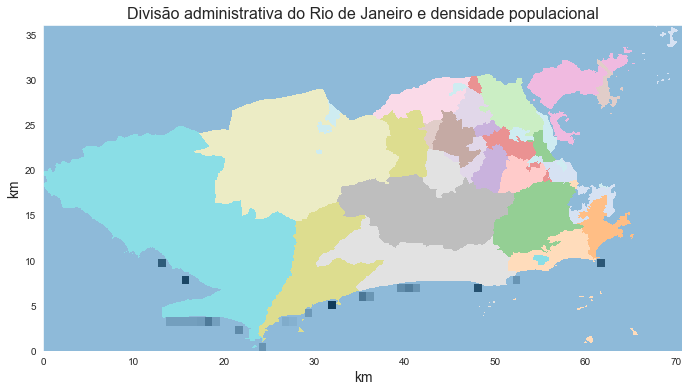

In [14]:
plt.figure(figsize=(12,6))
plt.imshow(geoloc_Bairros_MRJ_fino, cmap='tab20', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent])
plt.imshow(np.log(1 + landbad), cmap='binary', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent], alpha=0.5)
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Divisão administrativa do Rio de Janeiro e densidade populacional',
          fontsize=16)
plt.show()

In [ ]:
x = 20
y = 32
print(landscan_rio[x,y])
print(list(range(x*tx_refinamento_x,(x+1)*tx_refinamento_x)))
print(list(range(y*tx_refinamento_y, (y+1)*tx_refinamento_y)))
prob_fino_local = prob_fino[x*tx_refinamento_x:(x+1)*tx_refinamento_x,
                                        y*tx_refinamento_y:(y+1)*tx_refinamento_y]
prob_fino_local_flat = prob_fino_local.flatten()/prob_fino_local.sum()
distrib = np.rint(landscan_rio[x,y]*prob_fino_local_flat).astype('int')
print(f'Primeira distribuição (total {distrib.sum()}):\n', distrib)
print(prob_fino.shape)
print(prob_fino_local.shape)
#print(prob_fino_local)
#print(type(int(landscan_rio[x,y])))
#np.random.choice(tx_refinamento_x*tx_refinamento_y, int(landscan_rio[x,y]),
#                 replace=False, p=prob_fino_local_flat)
print(prob_fino_local.sum()/tx_refinamento_x/tx_refinamento_y)

In [ ]:
np.random.choice(100, 10, replace=False, p=prob_fino_local_flat)

In [ ]:
np.random.choice(100, 1000)

In [ ]:
landscan_rio_fino = refina_matriz_populacional(landscan_rio, geoloc_Bairros_MRJ_fino)

In [ ]:
print(landscan_rio.sum())
print(landscan_rio_fino.sum()/100)

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(np.log(1 + landscan_rio_fino), cmap='seismic', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent])
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Densidade de probabilidade de distribuição da população', fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(geoloc_Bairros_MRJ_fino, cmap='tab20', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent])
plt.imshow(np.log(1 + landscan_rio_fino), cmap='binary', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent], alpha=0.5)
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Divisão administrativa do Rio de Janeiro e densidade populacional',
          fontsize=16)
plt.show()

## Grau relativo de infectividade

- Cada indivíduo tem um potencial maior ou menor de transmitir a doença, de acordo com as suas características.

- Para levar isso em consideração, um parâmetro relativo (adimensional) $\rho_i$ é definido para cada indivíduo.

- Este parâmetro é tomado de acordo com uma [distribuição gama](https://en.wikipedia.org/wiki/Beta_distribution) com média 1 (ver [DeGroot & Schervish (2012)](#Referências)).

- Uma distribuição gama é caracterizada por dois *fatores de forma*, $\alpha$ e $\beta$.

- Com esses fatores, a função densidade de probabilidade (PDF) de gama é

$$
\begin{align}
f(x;\alpha,\beta) & = \frac{ \beta^\alpha x^{\alpha-1} e^{-\beta x}}{\Gamma(\alpha)} \quad \textrm{para } x > 0, \quad \textrm{com } \alpha, \beta > 0,
\end{align}
$$

- Acima, temos a função gama $\Gamma(\alpha) = \int_0^\infty x^{\alpha-1} e^{-x} \;\textrm{d}x$, necessária para que a integral de $f(x;\alpha,\beta)$ em $(0,\infty)$ seja 1 e, portanto, que ela seja a função densidade de uma probabilidade.

- Dados os parâmetros $\alpha$ e $\beta$, a distribuição gama tem como valor médio 

$$ \textrm{valor médio} = \frac{\alpha}{\beta}.
$$

- Como queremos média $1$, precisamos que $\alpha=\beta$.

- No nosso modelo, usamos os mesmos parâmetros utilizados pelo grupo do Imperial/Pitt, ver [Ferguson el al (2005)](#Referências), a saber $\alpha = \beta = 0.2$.

### Definindo a infectividade no scipy

- Utilizamos a função [scipy.stats.gamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html) para distribuir os valores de $\rho_i$.

- Também podemos utilizar [numpy.random.gamma](https://numpy.org/doc/stable/reference/random/generated/numpy.random.gamma.html).

- E utilizamos o método `scipy.stats.gamma.pdf` para visualizar a PDF da distribuição com esses parâmetros.

- Observe que o `scipy` define a função gama com parâmetros `a`, `loc` e `scale`:

```python
gamma.pdf(x, a, loc, scale) = gamma.pdf((x - loc) / scale, a) / scale
```

onde `gamma.pdf(x, a)` é dada por $x^{a-1}e^{-x}/\Gamma(a)$, ou seja,

$$ \textrm{gamma.pdf(x, a, loc, scale)} = \frac{(x-\textrm{loc})^{a-1}}{\textrm{scale}^a}\frac{\exp\left(-\frac{x-\textrm{loc}}{\textrm{scale}}\right)}{\Gamma(a)}.
$$

- Acima, `a` representa o parâmetro $\alpha$ e `loc` é um *deslocamento* na abcissa, que, no nosso caso, não estamos considerando. Por fim, `scale` é o inverso de $\beta$ (é o termo `k` na outra representação vista em [distribuição gama](https://en.wikipedia.org/wiki/Beta_distribution) e também o nome do argumento usado por [numpy.random.gamma](https://numpy.org/doc/stable/reference/random/generated/numpy.random.gamma.html)). 

- Assim, para o nosso caso, temos

$$ \textrm{gamma.pdf(x, a=alpha, loc=0, scale=1/beta)} = \beta^\alpha x^{\alpha-1}\frac{e^{-\beta x}}{\Gamma(\alpha)} = f(x; \alpha, \beta),
$$

### Construindo a distribuição da infectividade

- Abaixo, alguns gráficos para visualizar a distribuição de $\rho_i$ na população.

- Tomamos uma população de 1000 indivíduos para exemplificar.

- E fazemos `a` = $\alpha = 0.2$ e `scale` = $1/\beta = 5$ em [scipy.stats.gamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html).

In [ ]:
num_pop = 1000
rho_forma = 0.2
rho_escala = 5
ppf_min = 0.45
ppf_max = 0.95
gamma_x = np.linspace(stats.gamma.ppf(ppf_min, a=rho_forma, scale=rho_escala),
                      stats.gamma.ppf(ppf_max, a=rho_forma, scale=rho_escala),
                      200)
gamma_pdf = stats.gamma.pdf(gamma_x, a=rho_forma, scale=rho_escala)
rho = stats.gamma.rvs(a=rho_forma, scale=rho_escala, size=num_pop)
#rho = np.random.gamma(rho_forma, rho_escala, num_pop)
#%timeit rho = np.random.gamma(shape=rho_forma, scale=rho_escala, size=num_pop)
#%timeit rho = stats.gamma.rvs(a=rho_forma, scale=rho_escala, size=num_pop)
print('rho_i gerado de acordo com a distribuição gama')
print(f'- fator de forma: {rho_forma}')
print(f'- escala: {rho_escala}')
print(f'- valor médio: {rho_escala *rho_forma}')

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(gamma_x, gamma_pdf)
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$y$', fontsize=14)
plt.title(r'função densidade de probabilidade da distribuição gamma',
          fontsize=16)
plt.show()

### Visualizando a distribuição da infectividade

- A seguir, alguns gráficos para visualizar a distribuição de $\rho_i$ na população.

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(rho, 'o', markersize=4, label=r'$\rho_i$')
plt.plot(range(num_pop), np.mean(rho)*np.ones(num_pop), '--', label='média')
plt.xlabel(r'$i$', fontsize=14)
plt.ylabel(r'$rho_i$', fontsize=14)
plt.legend(fontsize=12)
plt.title(r'Valor de $\rho_i$ para cada um dos' + f' {num_pop} indivíduos' 
          + f' (média obtida: {np.mean(rho):.2f})', fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(rho, 'o', markersize=4, label=r'$\rho_i$')
plt.plot(range(num_pop), np.mean(rho)*np.ones(num_pop), '--', label='média')
plt.xlabel(r'$i$', fontsize=14)
plt.ylabel(r'$rho_i$', fontsize=14)
plt.yscale('log')
plt.legend(fontsize=12)
plt.title(r'Valor, em escala logarítmica, de $\rho_i$ para cada um dos'
          + f' {num_pop} indivíduos', fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(rho, bins=22)
#plt.plot(range(num_pop), np.mean(rho)*np.ones(num_pop), '--', label='média')
plt.xlabel(r'$\rho$', fontsize=14)
plt.ylabel(r'#{$\rho_i=\rho$}', fontsize=14)
#plt.yscale('log')
plt.title(r'Histograma da distribuição gamma de $\rho_i$'
          + f'\n(fator de forma {rho_forma:.1f} e escala {rho_escala:.1f}, com média {rho_forma*rho_escala:.2f})',
          fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(rho, bins=22)
#plt.plot(range(num_pop), np.mean(rho)*np.ones(num_pop), '--', label='média')
plt.xlabel(r'$\rho$', fontsize=14)
plt.ylabel(r'$\ln$ #{$\rho_i=\rho$}', fontsize=14)
plt.yscale('log')
plt.title(r'Histograma da distribuição gamma de $\rho_i$ em escala logarítmica'
          + f'\n(fator de forma {rho_forma:.1f} e escala {rho_escala:.1f}, com média {rho_forma*rho_escala:.2f})',
          fontsize=16)
plt.show()

## Referências

- [DeGroot MH, Schervish MJ (2012), Probability and Statistics, 4th edition, Pearson Education, Inc.](https://www.pearson.com/us/higher-education/program/De-Groot-Probability-and-Statistics-4th-Edition/PGM146802.html).

<!--NAVIGATOR-->

---
[<- O cenário da cidade do Rio de Janeiro: distribuição inicial de infectados](32.00-Cenario_Rio_Distribuicao_Infectados.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) 